<a href="https://colab.research.google.com/github/afabiani/ForexEA/blob/master/GOLD_USD_Fred_(SVR)_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

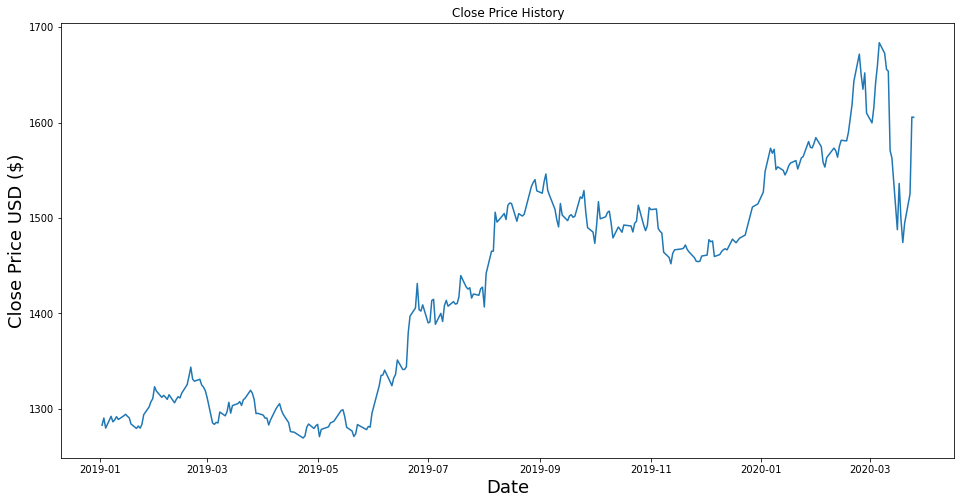

In [59]:
import os
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go

# Get the quotes
df = web.DataReader('GOLDPMGBD228NLBM', 'fred', '2019-01-01', '2020-03-25')
# Show the data
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df.index)
df.set_axis(df['Date'], inplace=True)

# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['GOLDPMGBD228NLBM'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [0]:
close_data = df['GOLDPMGBD228NLBM'].values
# close_data = close_data.reshape((-1,1))

#Create the lists / X and y data set
dates = []
prices = []

num_predictions = 15

def predict_dates(num_predictions):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_predictions+1).tolist()
    return prediction_dates

#Create the independent data set 'X' as dates
for date in df['Date']:
  dates.append([int(date.timestamp() * 1000)])
for pred in predict_dates(num_predictions):
  dates.append([int(pred.timestamp() * 1000)])

#Create the dependent data set 'y' as prices
for close_price in close_data:
  prices.append(float(close_price))

# For SVR we need Feature Scaling
sc_x = MinMaxScaler(feature_range=(-100, 100))
sc_y = MinMaxScaler(feature_range=(-100, 100))
# Scale x and y (two scale objects)
dates = sc_x.fit_transform(np.reshape(dates, (-1, 1)))
prices = sc_y.fit_transform(np.reshape(prices, (-1, 1)))
prices = prices.ravel()

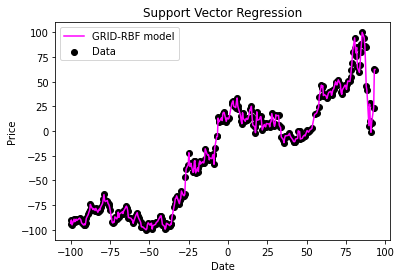

[[1429.04409125]]


In [87]:
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma='auto', epsilon=1.0, degree=3)
svr_lin = SVR(kernel='linear', C=1e3, gamma='auto')
svr_poly = SVR(kernel='poly', C=1e3, gamma='auto', epsilon=1.0, degree=3, coef0=1)

parameters = {
    "kernel": ["rbf"],
    "degree": [3, 6],
    "C": [1, 10, 100, 1000],
    "gamma": ['auto'],
    "epsilon": [0.1, 0.01, 0.001, 0.0001, 0.00001]
}

grid = GridSearchCV(SVR(), parameters, cv=5, verbose=0)

def predict_prices(dates, prices, x):
  # Train the models on the dates and prices
  #svr_lin.fit(dates, prices)
  #svr_poly.fit(dates, prices)
  #svr_rbf.fit(dates, prices)
  grid.fit(dates, prices)
  
  # Plot the models on a graph to see which has the best fit
  plt.scatter(dates, prices, color = 'black', label='Data')
  #plt.plot(dates, svr_rbf.predict(dates), color = 'red', label='RBF model')
  #plt.plot(dates, svr_lin.predict(dates), color = 'green', label='Linear model')
  #plt.plot(dates, svr_poly.predict(dates), color = 'blue', label='Polynomial model')
  plt.plot(dates, grid.predict(dates), color = 'magenta', label='GRID-RBF model')

  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Support Vector Regression')
  plt.legend()
  plt.show()
  
  # return all three model predictions
  return grid.predict(x)[0] # , svr_lin.predict(x)[0], svr_poly.predict(x)[0]

# Predict the price of Gold on next day
predicted_price = predict_prices(dates[:-num_predictions-1], prices, [[len(prices)-1]])
print(sc_y.inverse_transform(predicted_price.reshape(1, -1)))

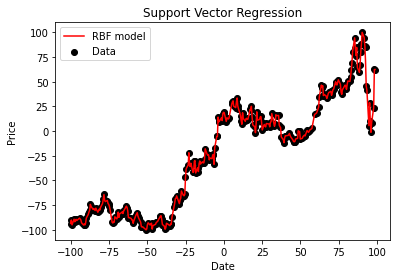

(310, 1)
(310,)


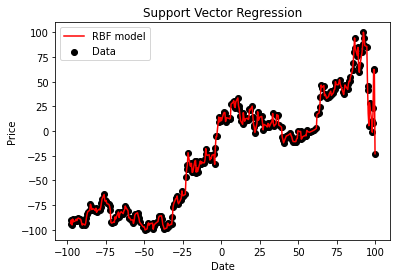

(311, 1)
(311,)


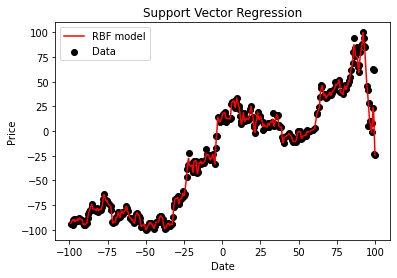

(312, 1)
(312,)


In [84]:
# Forecasting
def predict(forecast_dates, num_predictions, model):
    prediction_dates = dates[:-num_predictions-1]
    prediction_list = prices[:]

    for i in range(1, num_predictions+1):
        model.fit(prediction_dates, prediction_list)
        out = model.predict([[len(prediction_dates)+i]])[0]

        # Plot the models on a graph to see which has the best fit
        plt.scatter(prediction_dates, prediction_list, color = 'black', label='Data')
        plt.plot(prediction_dates, model.predict(prediction_dates), color = 'red', label='RBF model')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Support Vector Regression')
        plt.legend()
        plt.show()

        # Append the predicted values
        prediction_dates = dates[num_predictions+1-i:]
        prediction_list = np.append(prediction_list, np.reshape(float(out), (1, -1)) )

    return prediction_list

forecast_dates = predict_dates(num_predictions)
forecasts = predict(forecast_dates, num_predictions, grid)

In [85]:
# Plot the forecasts
trace1 = go.Scatter(
    x = df['Date'],
    y = close_data,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = sc_y.inverse_transform(forecasts.reshape(-1, 1)).reshape((-1))[-len(forecast_dates):],
    mode = 'lines',
    name = 'Forecasts'
)
layout = go.Layout(
    title = "Gold/USD",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()